# 16.6 Sequence level and token level applications using BERT
https://d2l.ai/chapter_natural-language-processing-applications/finetuning-bert.html

#### Summary: 
1. Wecanfine-tunethepretrainedBERTmodelfordownstreamapplications,suchasnatural language inference on the SNLI dataset.

2. During fine-tuning, the BERT model becomes part of the model for the downstream ap- plication. Parameters that are only related to pretraining loss will not be updated during fine-tuning.


#### Exercises and questions from 16.6

1. Let’s design a search engine algorithm for news articles. When the system receives an query (e.g., “oil industry during the coronavirus outbreak”), it should return a ranked list of news articles that are most relevant to the query. Suppose that we have a huge pool of news articles and a large number of queries. To simplify the problem, suppose that the most relevant article has been labeled for each query. How can we apply negative sampling (see Section 15.2.1) and BERT in the algorithm design?
2. How can we leverage BERT in training language models?
3. Can we leverage BERT in machine translation?

#### Exercises and 16.7
1. Fine-tuneamuchlargerpretrainedBERTmodelthatisaboutasbigastheoriginalBERT
base model if your computational resource allows. Set arguments in the load_pretrained_model function as: replacing ‘bert.small’ with ‘bert.base’, increasing values of num_hiddens=256, ffn_num_hiddens=512, num_heads=4, and num_blks=2 to 768, 3072, 12, and 12, re- spectively. By increasing fine-tuning epochs (and possibly tuning other hyperparameters),
can you get a testing accuracy higher than 0.86?

2. How to truncate a pair of sequences according to their ratio of length? Compare this pair truncation method and the one used in the SNLIBERTDataset class. What are their pros and cons?




# Natural Language Inferenece using BERT

1. Download pretrained BERT and fine tune for NLI task

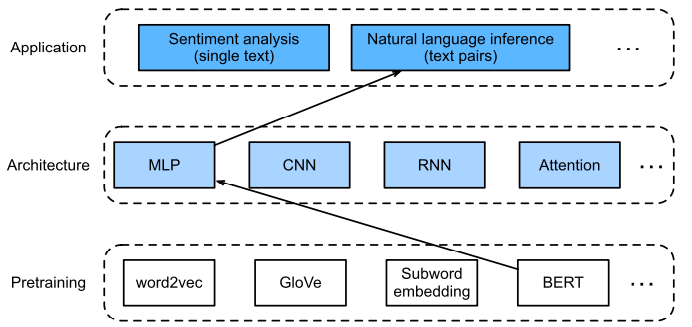

In [2]:
!pip install setuptools==66
!pip install matplotlib_inline
!pip install d2l==1.0.0b

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.1
    Uninstalling setuptools-67.6.1:
      Successfully uninstalled setuptools-67.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
devices = d2l.try_all_gpus()
print(devices)

In [3]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [4]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens, 
                          num_heads, num_blks, dropout, max_len, devices):
  data_dir = d2l.download_extract(pretrained_model)

  vocab = d2l.Vocab()
  #Load vocab from pretrained BERT
  vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))

  #create a token to index map
  vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}

  bert = d2l.BERTModel(
      len(vocab),
      num_hiddens, 
      ffn_num_hiddens,
      num_heads = 4, 
      num_blks=2, 
      dropout = 0.2, 
      max_len = max_len
  )

  #Load pretrained BERT params
  bert.load_state_dict(torch.load(os.path.join(data_dir, 'pretrained.params')))

  return bert, vocab


In [5]:
devices = d2l.try_all_gpus()
model_name = 'bert.small'
num_hiddens = 256
ffn_num_hiddens = 512
num_heads = 4
num_blks = 2
dropout = 0.1
max_len = 512


bert, vocab = load_pretrained_model(model_name, num_hiddens, 
                                    ffn_num_hiddens, num_heads, num_blks, dropout, max_len, devices)


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [29]:
class SNLIBertDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, max_len, vocab = None):
    all_premise_hypothesis_tokens = [
        [p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[
                d2l.tokenize([s.lower() for s in sentences]) for sentences in dataset[:2]
              ]
        )
    ]

    self.labels = torch.tensor(dataset[2])
    self.vocab = vocab
    self.max_len = max_len

    (self.all_token_ids, self.all_segments, self.valid_lens) = \
    self._preprocess(all_premise_hypothesis_tokens)

    print(f'read {len(self.all_token_ids)} examples')
  
  def _preprocess(self, all_premise_hypothesis_tokens):
    #multiprocessing
    '''
    @return (all_token_ids, all_segments, all_valid_lens)
    '''
    pool = multiprocessing.Pool(4)
    out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)

    all_token_ids = [token_ids for token_ids, segments, valid_len in out]
    all_segments = [segments for token_ids, segments, valid_len in out]
    valid_lens = [valid_len for token_ids, segments, valid_len in out]

    return (
        torch.tensor(all_token_ids, dtype=torch.long),
        torch.tensor(all_segments, dtype=torch.long),
        torch.tensor(valid_lens)
    )

  def _mp_worker(self, premise_hypothesis_tokens):
    '''
    @return truncated and padded (token_ids, segments, valid_len) using max_len
    '''
    p_tokens, h_tokens = premise_hypothesis_tokens
    self._truncate_pair_of_tokens(p_tokens, h_tokens)
    tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)

    #add padd
    token_ids = self.vocab[tokens] + [self.vocab['<vocab>']] * (self.max_len - len(tokens))
    # add 0s for hypothesis at the end 1,1,1,0,0,0,..
    segments = segments + [0] * (self.max_len - len(segments))
    
    valid_len = len(tokens)

    return token_ids, segments, valid_len
  
  def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
    '''
    @return premise and hypothesis tokens
    '''
    # -3 is because we want to reserve 3 slots for <CLS>, <SEP>, and <SEP> tokens
    while len(p_tokens) + len(h_tokens) > self.max_len - 3:
      if len(p_tokens) > len(h_tokens):
        #pop() removes the last element of array
        p_tokens.pop()
      else:
        h_tokens.pop()
    
  def __getitem__(self, idx):
    return (self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx]), self.labels[idx]
  
  def __len__(self):
    return len(self.all_token_ids)

In [30]:
batch_size, max_len, num_workers = 128, 128, d2l.get_dataloader_workers()

data_dir = d2l.download_extract('SNLI')
train_set = SNLIBertDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBertDataset(d2l.read_snli(data_dir, False),  max_len, vocab)


#create train iter with Dataloader
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers = num_workers)
test_iter = torch.utils.data.DataLoader(test_set, num_workers = num_workers)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [31]:
#Fine tune BERT with 1 MLP layers

class BERTClassifier(nn.Module):
  def __init__(self, bert):
    super(BERTClassifier, self).__init__()
    #Load pretrained BERT
    self.encoder = bert.encoder
    self.hidden = bert.hidden
    #MLP layer, 3 labels for NLI: entailment, contradiction, neutral

    #NOTE that MaskLM and NSP loss functions in BERT are not updated during fine tuning
    # because they are not neccesary for downstream applications
    self.output = nn.LazyLinear(3)

  def forward(self, inputs):
    print(inputs)
    tokens_X, segments_X, valid_lens_x = inputs
    encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
    return self.output(self.hidden(encoded_X[:, 0, :]))

[tensor([[   3,  227, 4087,  ...,    0,    0,    0],
        [   3,   12,  352,  ...,    0,    0,    0],
        [   3,    0,  862,  ...,    0,    0,    0],
        ...,
        [   3,  412, 3212,  ...,    0,    0,    0],
        [   3,   74,  120,  ...,    0,    0,    0],
        [   3,  263,    9,  ...,    0,    0,    0]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([20, 30, 30, 27, 32, 32, 21, 25, 19, 33, 19, 17, 23, 28, 44, 18, 19, 32,
        14, 20, 24, 39, 37, 28, 19, 26, 21, 19, 42, 22, 23, 19, 30, 29, 18, 22,
        22, 31, 22, 28, 31, 29, 27, 32, 27, 28, 30, 21, 20, 20, 23, 29, 28, 20,
        34, 29, 17, 33, 22, 24, 21, 22, 20, 32, 27, 24, 16, 25, 17, 26, 21, 16,
        35, 26, 36, 40, 19, 20, 17, 21, 20, 24, 32, 29, 32, 24, 26, 15, 23, 20,
        28, 22, 27, 16, 34, 24, 18, 24, 21, 22, 26, 3

IndexError: ignored

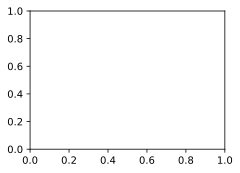

In [33]:
lr = 1e-4
epochs = 5

net = BERTClassifier(bert)
trainer = torch.optim.Adam(net.parameters(), lr = lr)
loss = nn.CrossEntropyLoss(reduction = 'none')
# what does this do?????
# print(next(iter(train_iter))[0])
# print(len(next(iter(train_iter))[0]))

net(next(iter(train_iter))[0])

d2l.train_ch13(net, train_iter, test_iter, loss, trainer, epochs, devices)

In [ ]:
#Questions
